# Custom CNN

In [1]:
#@title **Loading data from gdrive to memory**
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/ANNDL_Project

%cd ../../datasets

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/15O-hdeXPBICW_RJDpxFM_YoVERTpVMjK/ANNDL_Project


In [2]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 7.4 MB/s 


In [ ]:
!yes A | unzip data_splitted.zip -d data_splitted

Archive:  data_splitted.zip
replace val/Species7/00465.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: val/Species7/00465.jpg  
  inflating: val/Species7/00338.jpg  
  inflating: val/Species7/00186.jpg  
  inflating: val/Species7/00360.jpg  
  inflating: val/Species7/00295.jpg  
  inflating: val/Species7/00125.jpg  
  inflating: val/Species7/00136.jpg  
  inflating: val/Species7/00116.jpg  
  inflating: val/Species7/00437.jpg  
  inflating: val/Species7/00522.jpg  
  inflating: val/Species7/00087.jpg  
  inflating: val/Species7/00343.jpg  
  inflating: val/Species7/00036.jpg  
  inflating: val/Species7/00331.jpg  
  inflating: val/Species7/00236.jpg  
  inflating: val/Species7/00119.jpg  
  inflating: val/Species7/00327.jpg  
  inflating: val/Species7/00232.jpg  
  inflating: val/Species7/00273.jpg  
  inflating: val/Species7/00397.jpg  
  inflating: val/Species7/00051.jpg  
  inflating: val/Species7/00443.jpg  
  inflating: val/Species7/00350.jpg  
  inflating: val/Species7/00

In [4]:
#@title **Imports**
import warnings
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import os
import random
import pandas as pd
import scipy
from datetime import datetime
from google.colab import files

In [5]:
#@title **Metadata and variables**

tfk = tf.keras
tfkl = tf.keras.layers

dir = "data_splitted"
# dir = "training_data_final"

input_shape = (96, 96, 3)
nclasses = 8
epochs = 200
seed = 42


In [ ]:
#@title **Setting seed and/or suppressing warnings**
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Setting random seed for reproducibility
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
#@title **Method that returns ImageDataGenerators (iterators) of augmented images**
def get_dataset_generator(dir):

    train_dir = dir + "/train"
    test_dir = dir + "/test"
    val_dir = dir + "/val"


    train_data_gen = ImageDataGenerator(rotation_range=15,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        )

    valid_data_gen = ImageDataGenerator(
        # rescale=1 / 255.
        )
    test_data_gen = ImageDataGenerator(
        # rescale=1 / 255.
        )

    train_gen = train_data_gen.flow_from_directory(directory=train_dir,
                                                           target_size=(input_shape[0], input_shape[1]),
                                                           color_mode='rgb',
                                                           class_mode='categorical',
                                                           batch_size=64,
                                                           shuffle=True)
    valid_gen = valid_data_gen.flow_from_directory(directory=val_dir,
                                                   target_size=(input_shape[0], input_shape[1]),
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   batch_size=64,
                                                   shuffle=True)
    test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                                 target_size=(input_shape[0], input_shape[1]),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=64,
                                                 shuffle=True)

    return train_gen, valid_gen, test_gen

In [ ]:
#@title **Utility function to create folders and callbacks for training**
def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('trained_models/citte')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%m-%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_dir + '/cp-{val_accuracy:.2f}-{epoch:02d}.ckpt', # Checkpoint is saved with validation accuracy in the filename
                                                     monitor='val_accuracy',
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=True, # True to save only the best epoch 
                                                     initial_value_threshold=0.7
                                                     ) # Model is saved only if val_accuracy > initial_value_threshold

  callbacks.append(ckpt_callback)


  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks, exp_dir



---

# **CNN implementation**

In [6]:
def build_CNN(input_shape):
      # Build the neural network layer by layer
      input_layer = tfkl.Input(shape=input_shape, name='input_layer')

      conv1 = tfkl.Conv2D(
          filters=16,
          kernel_size=3,
          padding='same',
          activation='relu',
          kernel_initializer=tfk.initializers.HeUniform(seed)
      )(input_layer)
      norm1 = tfkl.BatchNormalization()(conv1)
      pool1 = tfkl.MaxPooling2D()(norm1)

      conv2 = tfkl.Conv2D(
          filters=32,
          kernel_size=3,
          padding='same',
          activation='relu',
          kernel_initializer=tfk.initializers.HeUniform(seed)
      )(pool1)
      norm2 = tfkl.BatchNormalization()(conv2)
      pool2 = tfkl.MaxPooling2D()(norm2)

      conv3 = tfkl.Conv2D(
          filters=64,
          kernel_size=3,
          padding='same',
          activation='relu',
          kernel_initializer=tfk.initializers.HeUniform(seed)
      )(pool2)
      norm3 = tfkl.BatchNormalization()(conv3)
      pool3 = tfkl.MaxPooling2D()(norm3)

      conv4 = tfkl.Conv2D(
          filters=128,
          kernel_size=3,
          padding='same',
          activation='relu',
          kernel_initializer=tfk.initializers.HeUniform(seed)
      )(pool3)
      norm4 = tfkl.BatchNormalization()(conv4)
      pool4 = tfkl.MaxPooling2D()(norm4)

      flattening_layer = tfkl.Flatten(name='Flatten')(pool4)
      dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
      classifier_layer = tfkl.Dense(units=256, name='Classifier1', kernel_initializer=tfk.initializers.HeUniform(seed),
                                    activation='relu')(dropout)
      dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
      classifier_layer = tfkl.Dense(units=128, name='Classifier2', kernel_initializer=tfk.initializers.HeUniform(seed),
                                    activation='relu')(dropout)                          
      dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
      output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed),
                                name='output_layer')(dropout)

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      # Compile the model
      model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
      
      # Return the model
      return model

model = build_CNN(input_shape)

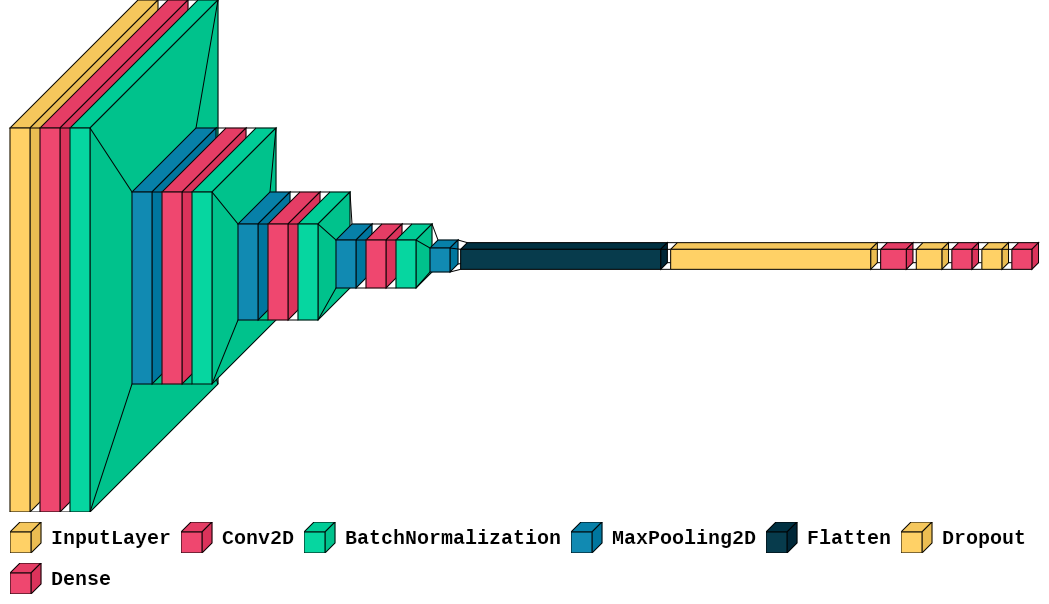

In [13]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 20)
visualkeras.layered_view(model, legend=True, font=font, max_z=200)

In [ ]:
model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128   

In [ ]:
#@title Training of the CNN
aug_callbacks, model_folder_dir = create_folders_and_callbacks(model_name='CNN_CB')

train_gen, val_gen, test_gen = get_dataset_generator(dir)

# Train the model
history = model.fit(
    x=train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks = aug_callbacks
).history

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.
Epoch 1/200
45/45 [==============================] - 378s 8s/step - loss: 2.7364 - accuracy: 0.2298 - val_loss: 4.6035 - val_accuracy: 0.1852
Epoch 2/200
45/45 [==============================] - 12s 264ms/step - loss: 1.8840 - accuracy: 0.3174 - val_loss: 2.3093 - val_accuracy: 0.2108
Epoch 3/200
45/45 [==============================] - 12s 263ms/step - loss: 1.7834 - accuracy: 0.3446 - val_loss: 1.9070 - val_accuracy: 0.2593
Epoch 4/200
45/45 [==============================] - 12s 265ms/step - loss: 1.6794 - accuracy: 0.3800 - val_loss: 1.8473 - val_accuracy: 0.2621
Epoch 5/200
45/45 [==============================] - 12s 267ms/step - loss: 1.5940 - accuracy: 0.4206 - val_loss: 1.8166 - val_accuracy: 0.2764
Epoch 6/200
45/45 [==============================] - 12s 262ms/step - loss: 1.5819 - accuracy: 0.4139 - val_loss: 1.8798 - val_accuracy: 0.2507
Epoch 7/200
45


---

**Save of models**


In [ ]:
model.save("saved_models/...")



---

**Loading of models**

In [ ]:
#@title **Loading of an existing model (having only the weights)**

model = build_CNN(input_shape=input_shape)
model.load_weights('trained_models/...')

In [ ]:
#@title **Loading of an existing model (Complete)**
model = tf.keras.models.load_model("saved_models/...")



---
**Model testing**


In [ ]:
train_gen, val_gen, test_gen = get_dataset_generator(dir)

model_test_metrics = model.evaluate(test_gen, return_dict=True)

6/6 [==============================] - 40s 8s/step - loss: 1.0355 - accuracy: 0.6851


In [ ]:
#@title **Testing a model and re-saving**

# saving model in saved_models/modelname_accuracy
saved_model_name = 'CNN_' + str(model_test_metrics["accuracy"])
saved_model_dir = 'saved_models/' + saved_model_name
model.save(saved_model_dir)



---
**Download of the model in .zip format**


In [ ]:
zipped_model = saved_model_dir + '/' + saved_model_name + '.zip'

In [ ]:
!zip -r {zipped_model} {saved_model_dir}

In [ ]:
files.download(zipped_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---

